In [1]:
# Import necessary modules
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import *

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 0.1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = True,
    verbose          = True
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Cost function weights

In [6]:
ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

## Input Disturbances

In [7]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [8]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Control Inputs

In [9]:
# Carla test params
irrigation_frequency = 24 * 7 * 2 # Irrigate once every 336 hours
irrigation_amount    = 0.01        # with 0.01 inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = 24 * 30 * 3 # Fertilize once every 2160 hours
fertilizer_amount    = 175        # with 175 lbs per fertilization (goal is 355 lbs over season)

In [10]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(irrigation_frequency).astype(int)):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, np.floor(fertilizer_frequency).astype(int)):
    hourly_fertilizer[t] = fertilizer_amount

In [11]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly

hourly_irrigation = np.zeros(simulation_hours)
step_if = max(1, int(np.ceil(irrigation_frequency)))
hourly_irrigation[::step_if] = irrigation_amount
irrigation = get_sim_inputs_from_hourly(hourly_irrigation, model_params.dt, simulation_hours, mode='split')

hourly_fertilizer = np.zeros(simulation_hours)
step_ff = max(1, int(np.ceil(fertilizer_frequency)))
hourly_fertilizer[::step_ff] = fertilizer_amount
fertilizer = get_sim_inputs_from_hourly(hourly_fertilizer, model_params.dt, simulation_hours, mode='split')

temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature, model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation, model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

## Optimal/Typical Values

In [12]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

## GA Params (just to use Member class)

In [13]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams()

## Simulation of Plant Growth over Season for Different Sensitivities

In [14]:
# Define sweeps for sensitivity analysis
sigma_Ws = [10, 20, 30, 50, 100, 200, 300, 500]
sigma_Fs = [10, 20, 30, 50, 100, 200, 300, 500]
sigma_Ts = [10, 20, 30, 50, 100, 200, 300, 500]
sigma_Rs = [10, 20, 30, 50, 100, 200, 300, 500]

# Set default sensitivity values
sigma_W_default = 30
sigma_F_default = 300
sigma_T_default = 30
sigma_R_default = 30

## Simulate over different WATER sensitivities

In [15]:
# Loop over sensitivity values for nuW using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

labels = []

for sigma_W in sigma_Ws:
    print(f"Running simulation with water sensitivity: {sigma_W}")
    labels.append(r'$\sigma_{W}$ =' + f' {sigma_W}')

    # Set ModelSensitivities
    sensitivities = ModelSensitivities(
        sigma_W = sigma_W,
        sigma_F = sigma_F_default,
        sigma_T = sigma_T_default,
        sigma_R = sigma_R_default
    )

    # Construct an instance of the Member class
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())

    nuWs.append(output['nuW'].to_numpy())
    nuFs.append(output['nuF'].to_numpy())
    nuTs.append(output['nuT'].to_numpy())
    nuRs.append(output['nuR'].to_numpy())

    ah_hats.append(output['ah_hat'].to_numpy())
    aA_hats.append(output['aA_hat'].to_numpy())
    aN_hats.append(output['aN_hat'].to_numpy())
    ac_hats.append(output['ac_hat'].to_numpy())
    aP_hats.append(output['aP_hat'].to_numpy())

    kh_hats.append(output['kh_hat'].to_numpy())
    kA_hats.append(output['kA_hat'].to_numpy())
    kN_hats.append(output['kN_hat'].to_numpy())
    kc_hats.append(output['kc_hat'].to_numpy())
    kP_hats.append(output['kP_hat'].to_numpy())

Running simulation with water sensitivity: 10
Running simulation with water sensitivity: 20
Running simulation with water sensitivity: 30
Running simulation with water sensitivity: 50
Running simulation with water sensitivity: 100
Running simulation with water sensitivity: 200
Running simulation with water sensitivity: 300
Running simulation with water sensitivity: 500


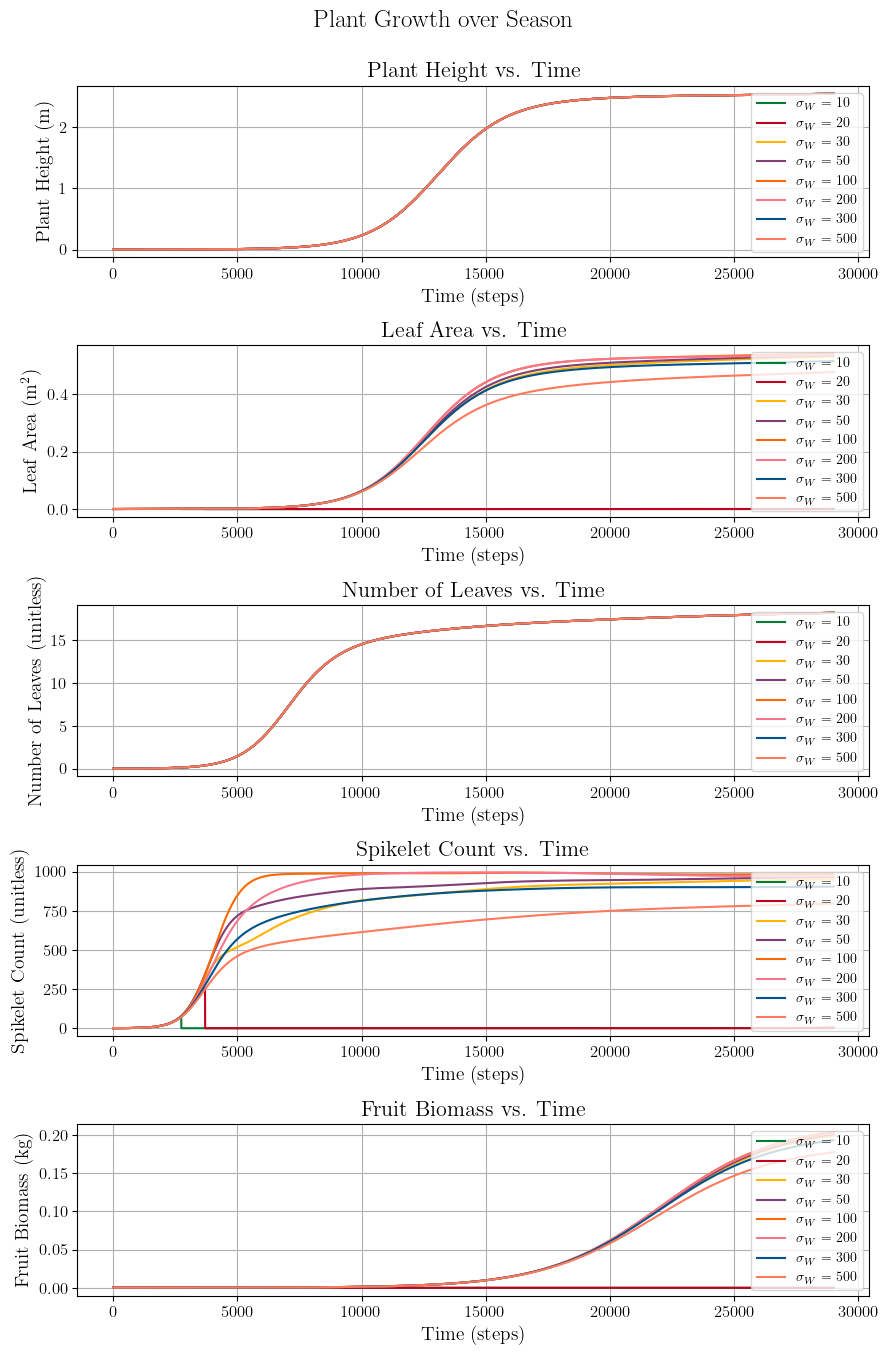

In [16]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

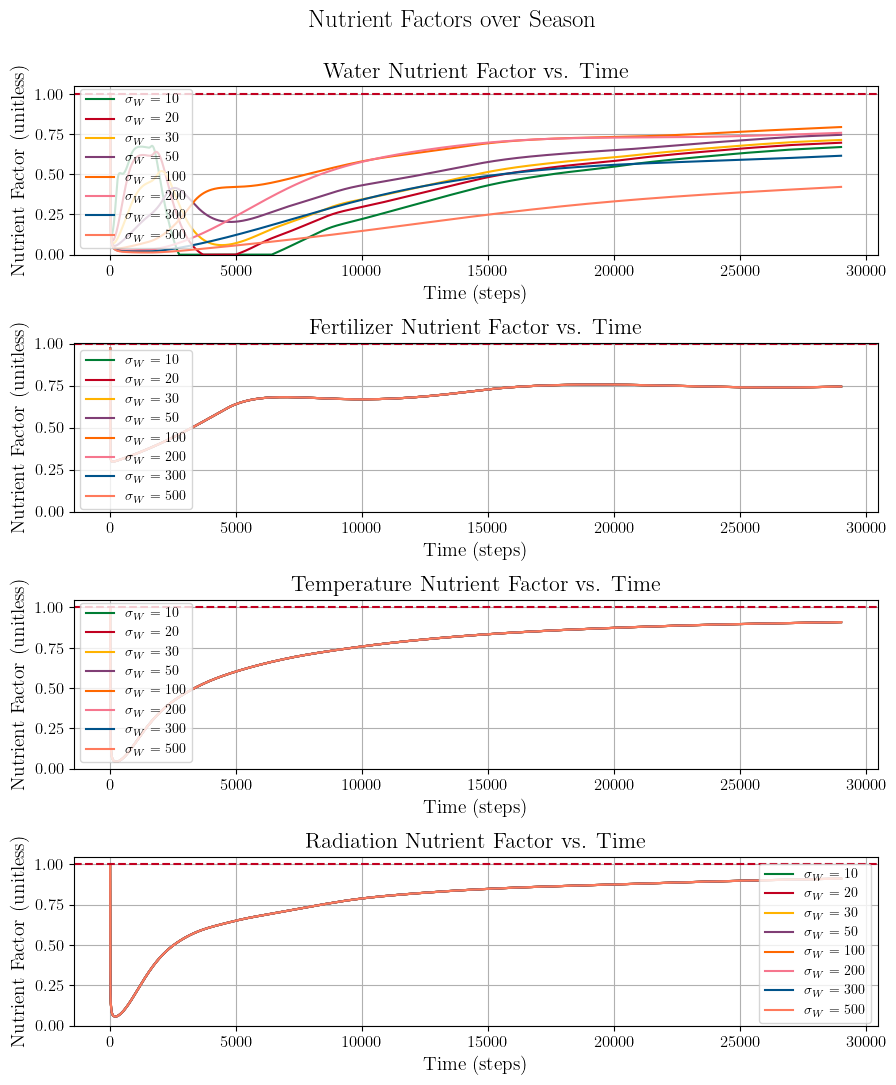

In [18]:
# Plot nuW, nuF, nuT, and nuF over time
plot_nutrient_factor_evolution(
    nuWs=nuWs,
    nuFs=nuFs,
    nuTs=nuTs,
    nuRs=nuRs,
    labels=labels
)

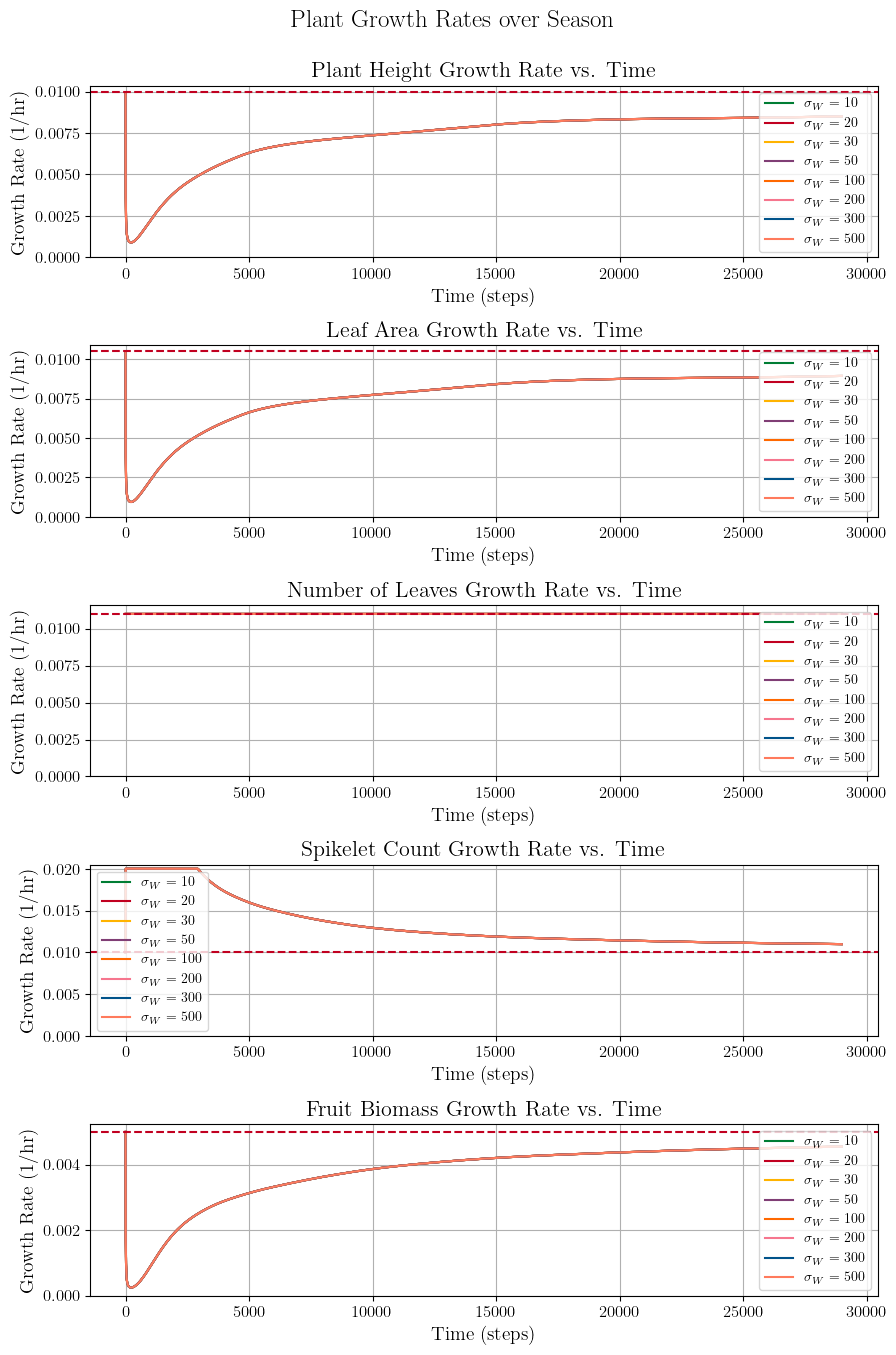

In [19]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    labels=labels
)

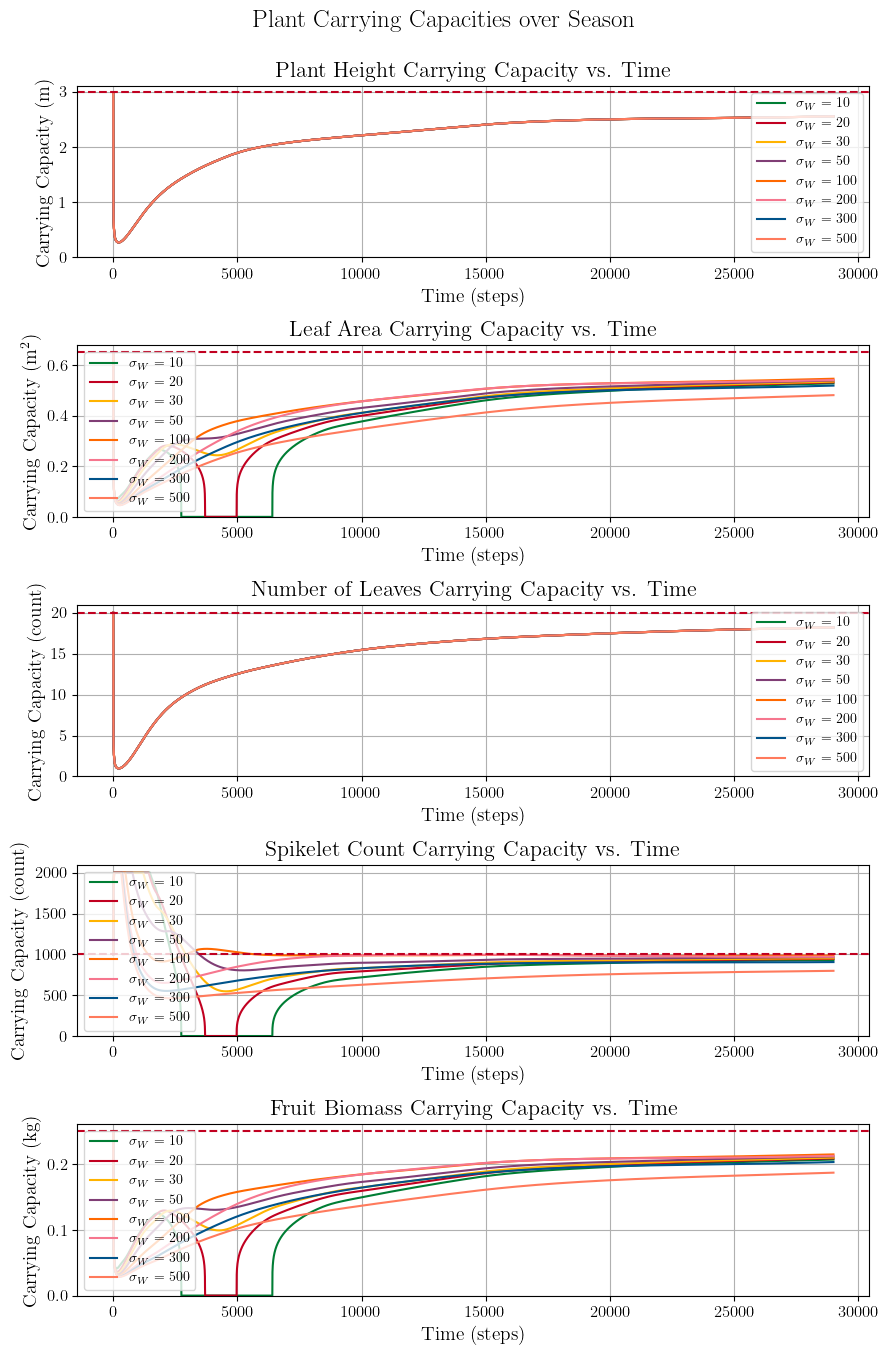

In [20]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    labels=labels
)

## Simulate over different FERTILIZER sensitivities

In [22]:
# Loop over sensitivity values for nuW using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

labels = []

for sigma_F in sigma_Fs:
    print(f"Running simulation with fertilizer sensitivity: {sigma_F}")
    labels.append(r'$\sigma_{F}$ =' + f' {sigma_F}')

    # Set ModelSensitivities
    sensitivities = ModelSensitivities(
        sigma_W = sigma_W_default,
        sigma_F = sigma_F,
        sigma_T = sigma_T_default,
        sigma_R = sigma_R_default
    )

    # Construct an instance of the Member class
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())

    nuWs.append(output['nuW'].to_numpy())
    nuFs.append(output['nuF'].to_numpy())
    nuTs.append(output['nuT'].to_numpy())
    nuRs.append(output['nuR'].to_numpy())

    ah_hats.append(output['ah_hat'].to_numpy())
    aA_hats.append(output['aA_hat'].to_numpy())
    aN_hats.append(output['aN_hat'].to_numpy())
    ac_hats.append(output['ac_hat'].to_numpy())
    aP_hats.append(output['aP_hat'].to_numpy())

    kh_hats.append(output['kh_hat'].to_numpy())
    kA_hats.append(output['kA_hat'].to_numpy())
    kN_hats.append(output['kN_hat'].to_numpy())
    kc_hats.append(output['kc_hat'].to_numpy())
    kP_hats.append(output['kP_hat'].to_numpy())

Running simulation with fertilizer sensitivity: 10
Running simulation with fertilizer sensitivity: 20
Running simulation with fertilizer sensitivity: 30
Running simulation with fertilizer sensitivity: 50
Running simulation with fertilizer sensitivity: 100
Running simulation with fertilizer sensitivity: 200
Running simulation with fertilizer sensitivity: 300
Running simulation with fertilizer sensitivity: 500


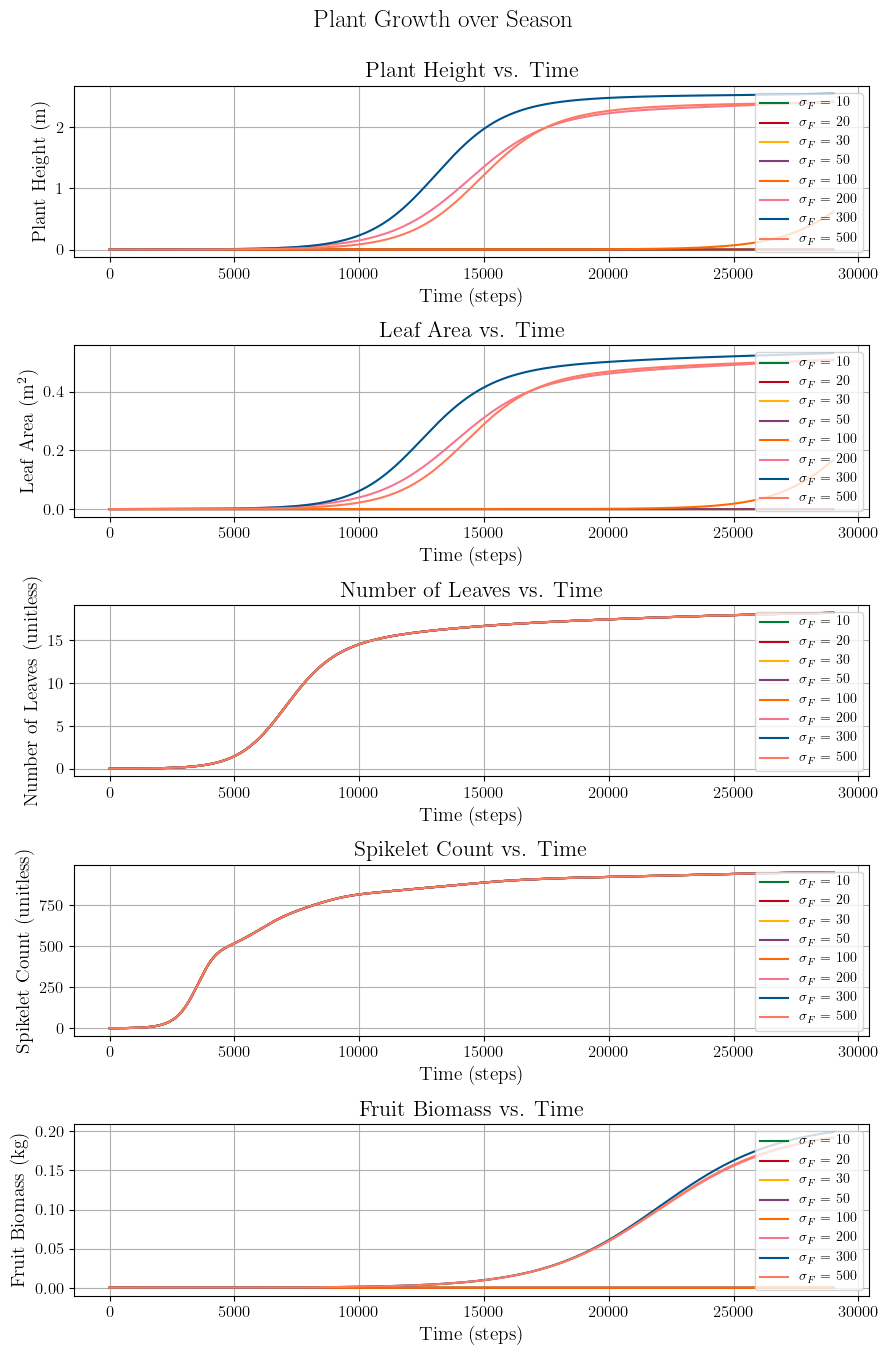

In [23]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

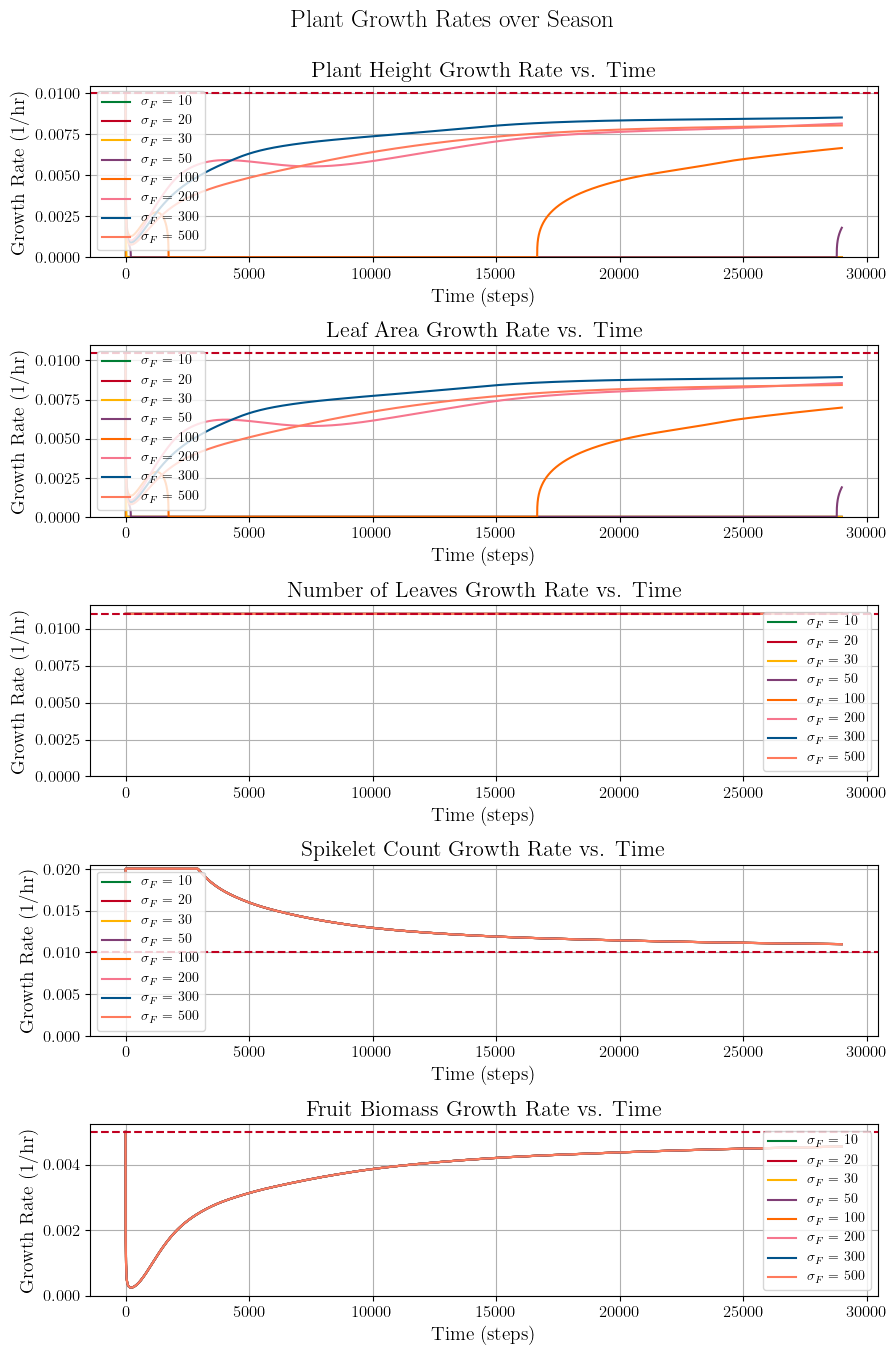

In [24]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    labels=labels
)

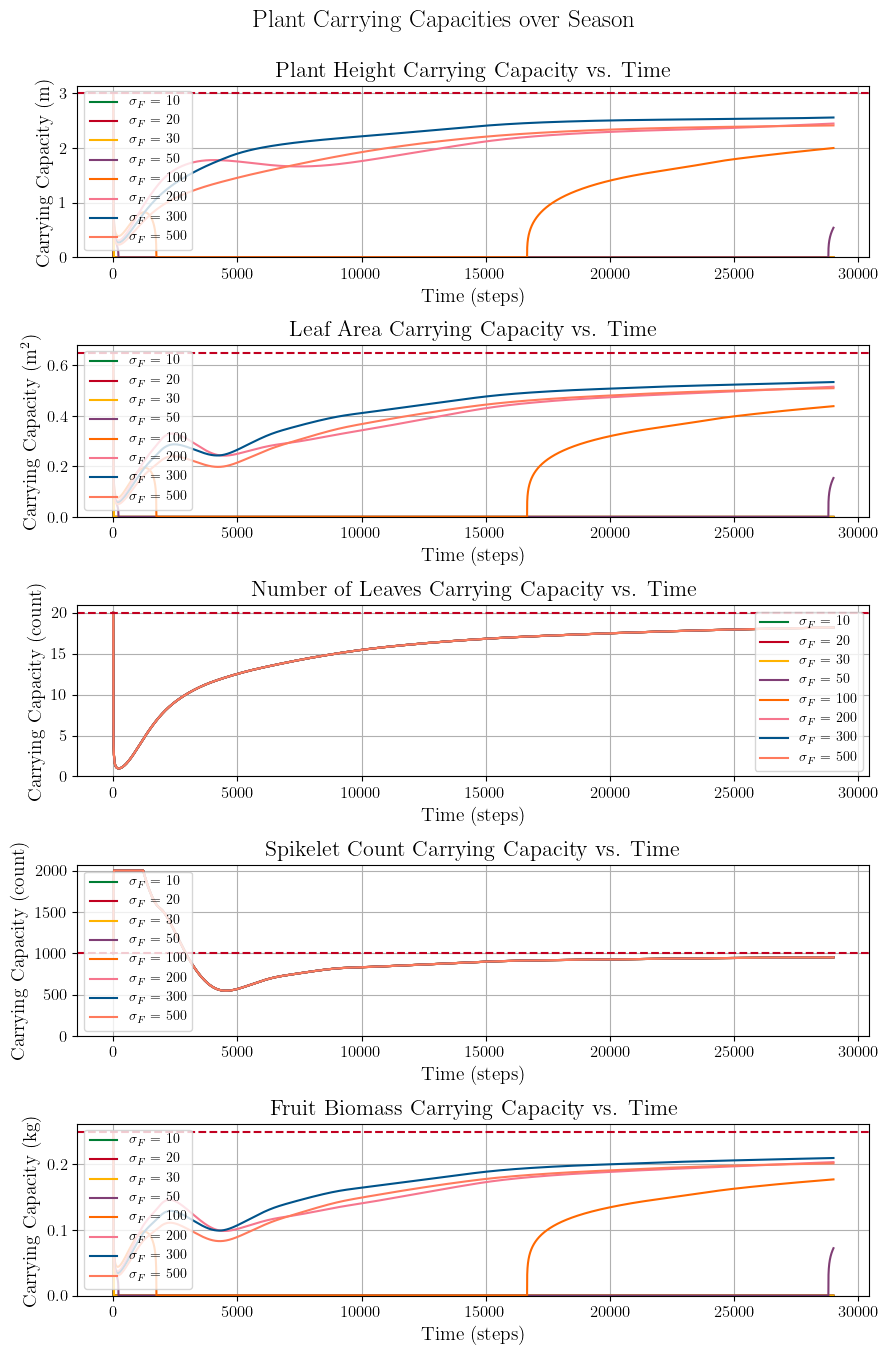

In [25]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    labels=labels
)

## Simulate over different TEMPERATURE sensitivities

In [26]:
# Loop over sensitivity values for nuW using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

labels = []

for sigma_T in sigma_Ts:
    print(f"Running simulation with temperature sensitivity: {sigma_T}")
    labels.append(r'$\sigma_{T}$ =' + f' {sigma_T}')

    # Set ModelSensitivities
    sensitivities = ModelSensitivities(
        sigma_W = sigma_W_default,
        sigma_F = sigma_F_default,
        sigma_T = sigma_T,
        sigma_R = sigma_R_default
    )

    # Construct an instance of the Member class
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())

    nuWs.append(output['nuW'].to_numpy())
    nuFs.append(output['nuF'].to_numpy())
    nuTs.append(output['nuT'].to_numpy())
    nuRs.append(output['nuR'].to_numpy())

    ah_hats.append(output['ah_hat'].to_numpy())
    aA_hats.append(output['aA_hat'].to_numpy())
    aN_hats.append(output['aN_hat'].to_numpy())
    ac_hats.append(output['ac_hat'].to_numpy())
    aP_hats.append(output['aP_hat'].to_numpy())

    kh_hats.append(output['kh_hat'].to_numpy())
    kA_hats.append(output['kA_hat'].to_numpy())
    kN_hats.append(output['kN_hat'].to_numpy())
    kc_hats.append(output['kc_hat'].to_numpy())
    kP_hats.append(output['kP_hat'].to_numpy())

Running simulation with temperature sensitivity: 10
Running simulation with temperature sensitivity: 20
Running simulation with temperature sensitivity: 30
Running simulation with temperature sensitivity: 50
Running simulation with temperature sensitivity: 100
Running simulation with temperature sensitivity: 200
Running simulation with temperature sensitivity: 300
Running simulation with temperature sensitivity: 500


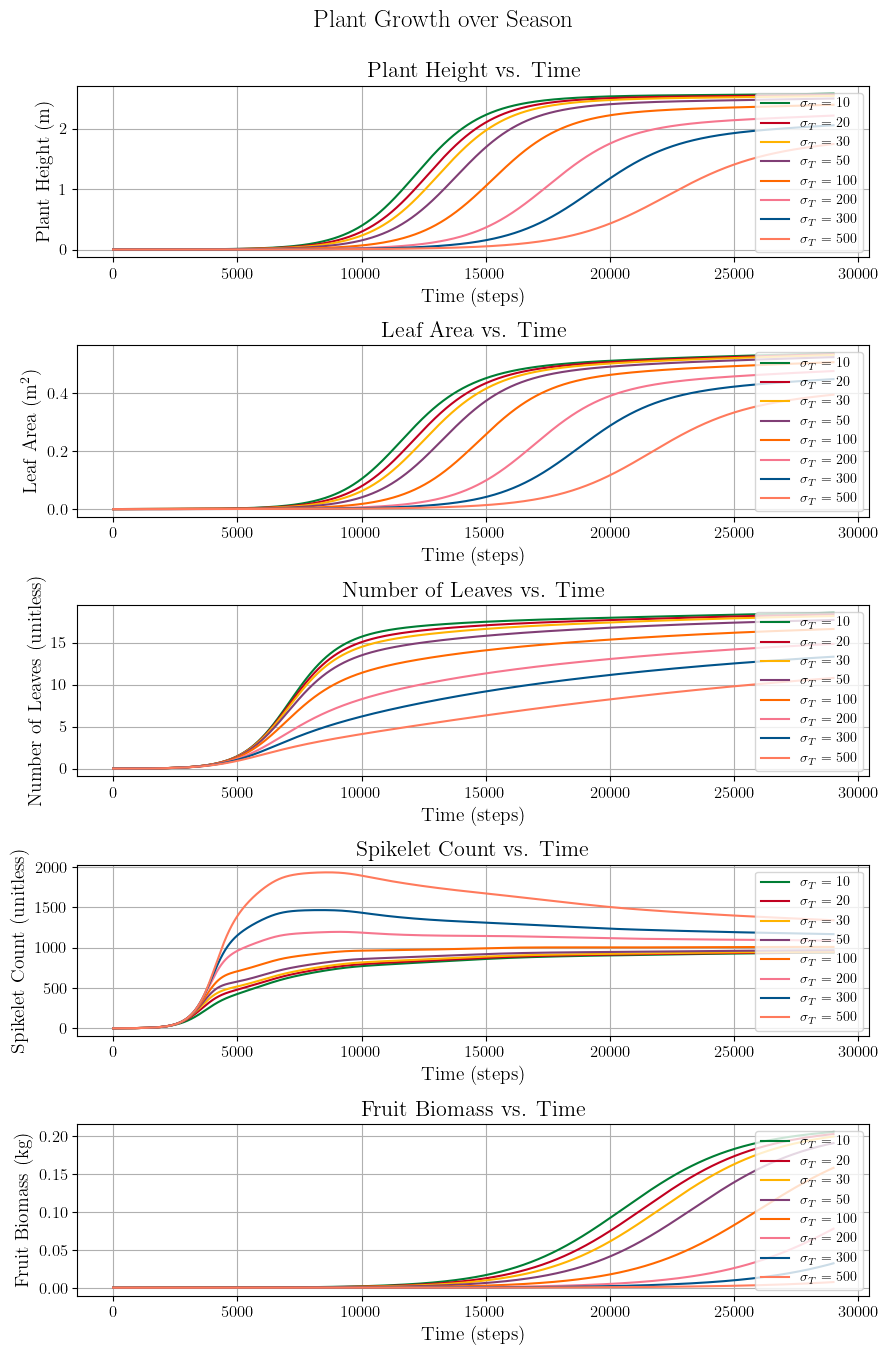

In [27]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

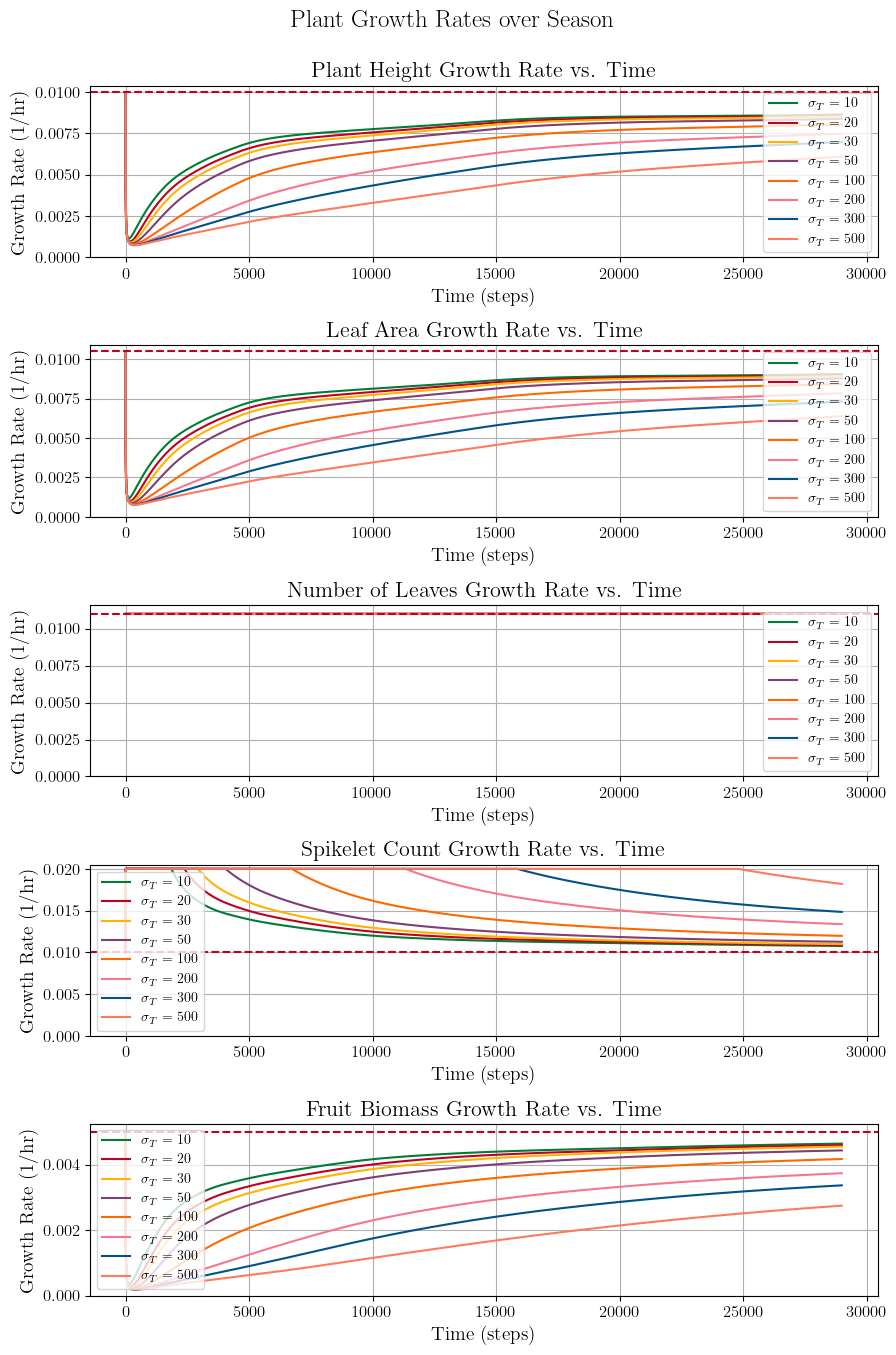

In [28]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    labels=labels
)

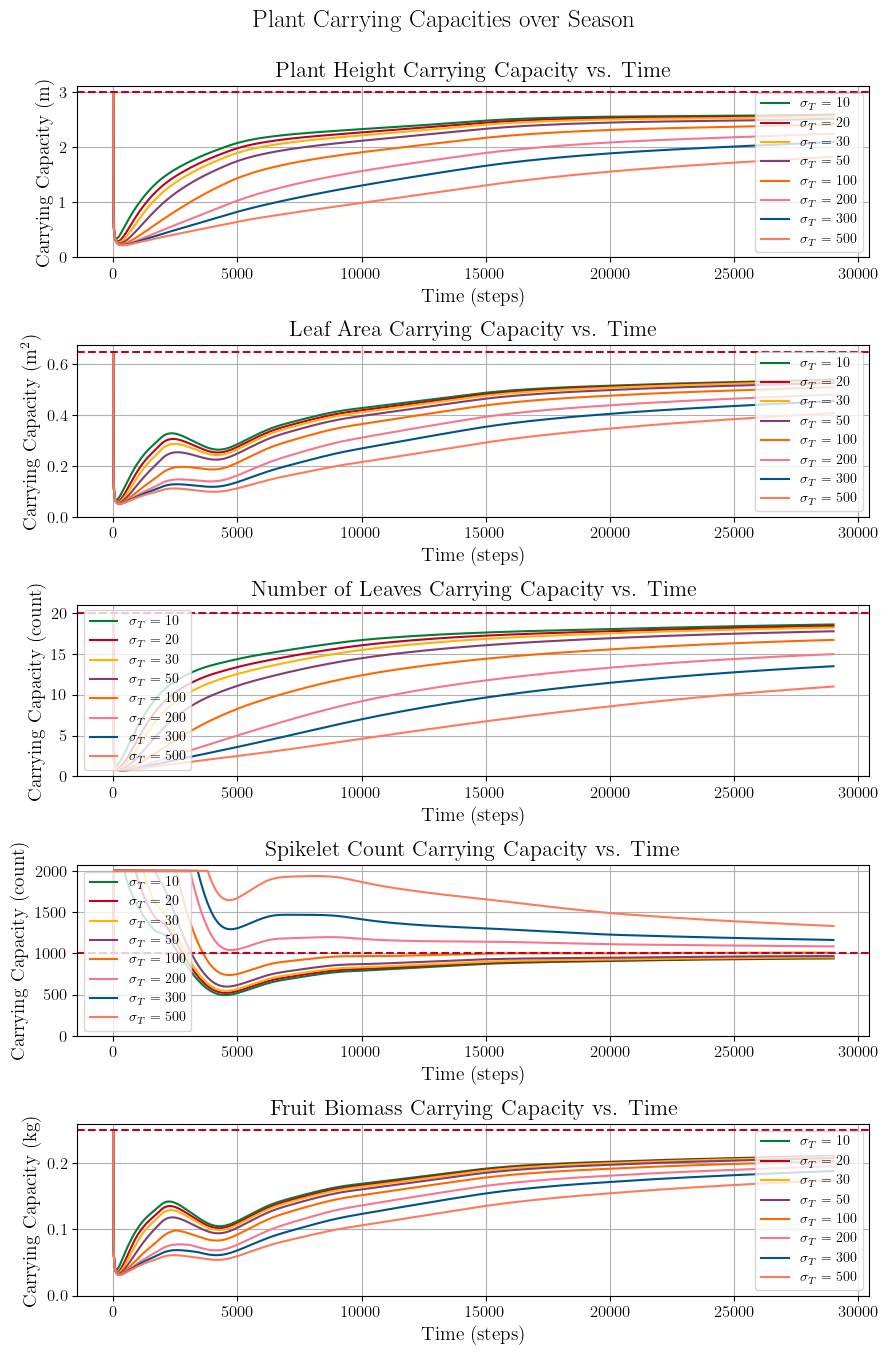

In [29]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    labels=labels
)

## Simulate over different RADIATION sensitivities

In [30]:
# Loop over sensitivity values for nuW using default values for others
hs = []
As = []
Ns = []
cs = []
Ps = []

nuWs = []
nuFs = []
nuTs = []
nuRs = []

ah_hats = []
aA_hats = []
aN_hats = []
ac_hats = []
aP_hats = []

kh_hats = []
kA_hats = []
kN_hats = []
kc_hats = []
kP_hats = []

labels = []

for sigma_R in sigma_Rs:
    print(f"Running simulation with water sensitivity: {sigma_R}")
    labels.append(r'$\sigma_{R}$ =' + f' {sigma_R}')

    # Set ModelSensitivities
    sensitivities = ModelSensitivities(
        sigma_W = sigma_W_default,
        sigma_F = sigma_F_default,
        sigma_T = sigma_T_default,
        sigma_R = sigma_R
    )

    # Construct an instance of the Member class
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = input_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
    )
    member.get_cost()

    # Read output CSV
    output = pd.read_csv('output_get_cost.csv')

    hs.append(output['h'].to_numpy())
    As.append(output['A'].to_numpy())
    Ns.append(output['N'].to_numpy())
    cs.append(output['c'].to_numpy())
    Ps.append(output['P'].to_numpy())

    nuWs.append(output['nuW'].to_numpy())
    nuFs.append(output['nuF'].to_numpy())
    nuTs.append(output['nuT'].to_numpy())
    nuRs.append(output['nuR'].to_numpy())

    ah_hats.append(output['ah_hat'].to_numpy())
    aA_hats.append(output['aA_hat'].to_numpy())
    aN_hats.append(output['aN_hat'].to_numpy())
    ac_hats.append(output['ac_hat'].to_numpy())
    aP_hats.append(output['aP_hat'].to_numpy())

    kh_hats.append(output['kh_hat'].to_numpy())
    kA_hats.append(output['kA_hat'].to_numpy())
    kN_hats.append(output['kN_hat'].to_numpy())
    kc_hats.append(output['kc_hat'].to_numpy())
    kP_hats.append(output['kP_hat'].to_numpy())

Running simulation with water sensitivity: 10
Running simulation with water sensitivity: 20
Running simulation with water sensitivity: 30
Running simulation with water sensitivity: 50
Running simulation with water sensitivity: 100
Running simulation with water sensitivity: 200
Running simulation with water sensitivity: 300
Running simulation with water sensitivity: 500


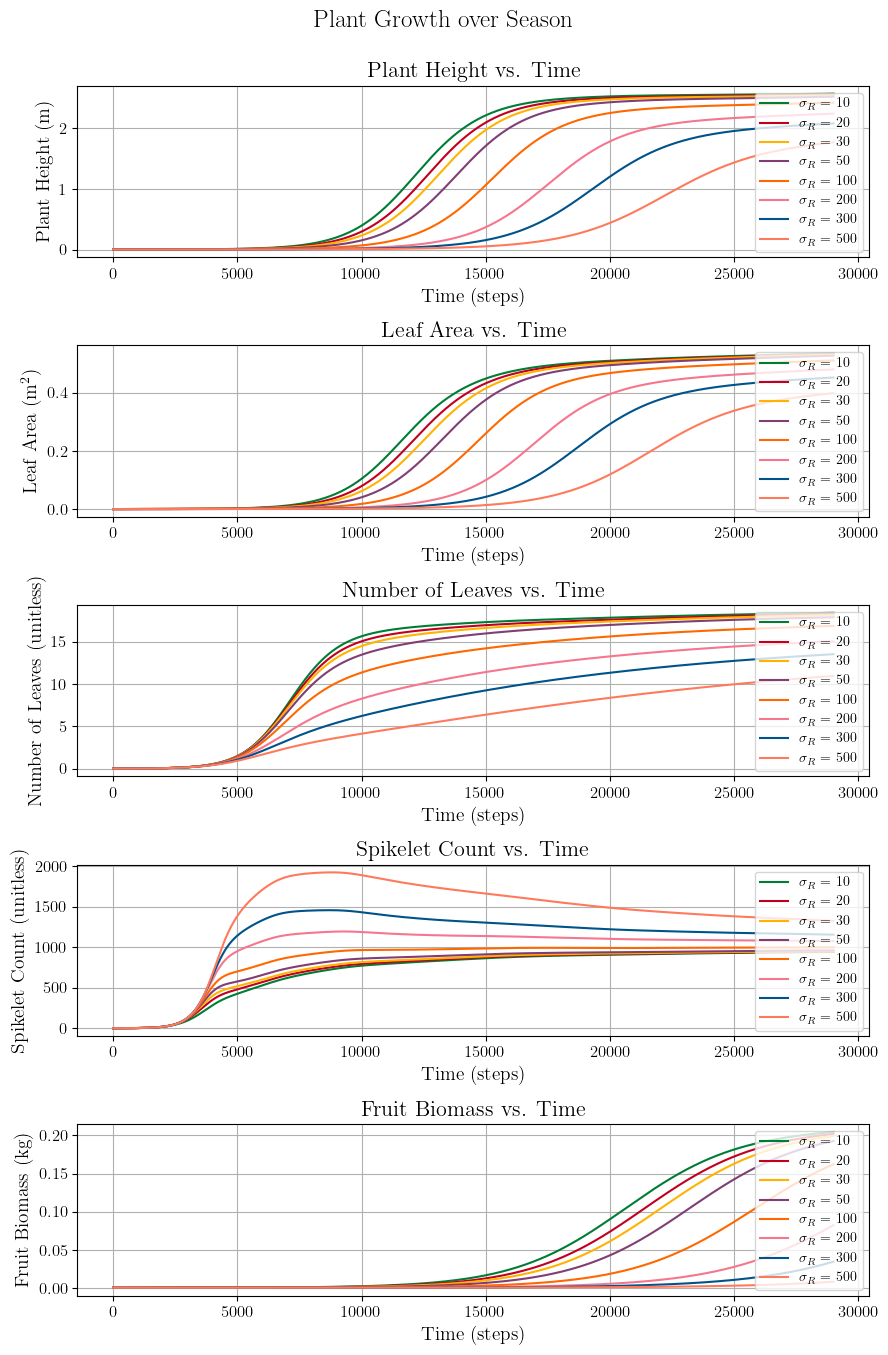

In [31]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
plot_crop_growth_results(
    hs=hs,
    As=As,
    Ns=Ns,
    cs=cs,
    Ps=Ps,
    labels=labels
)

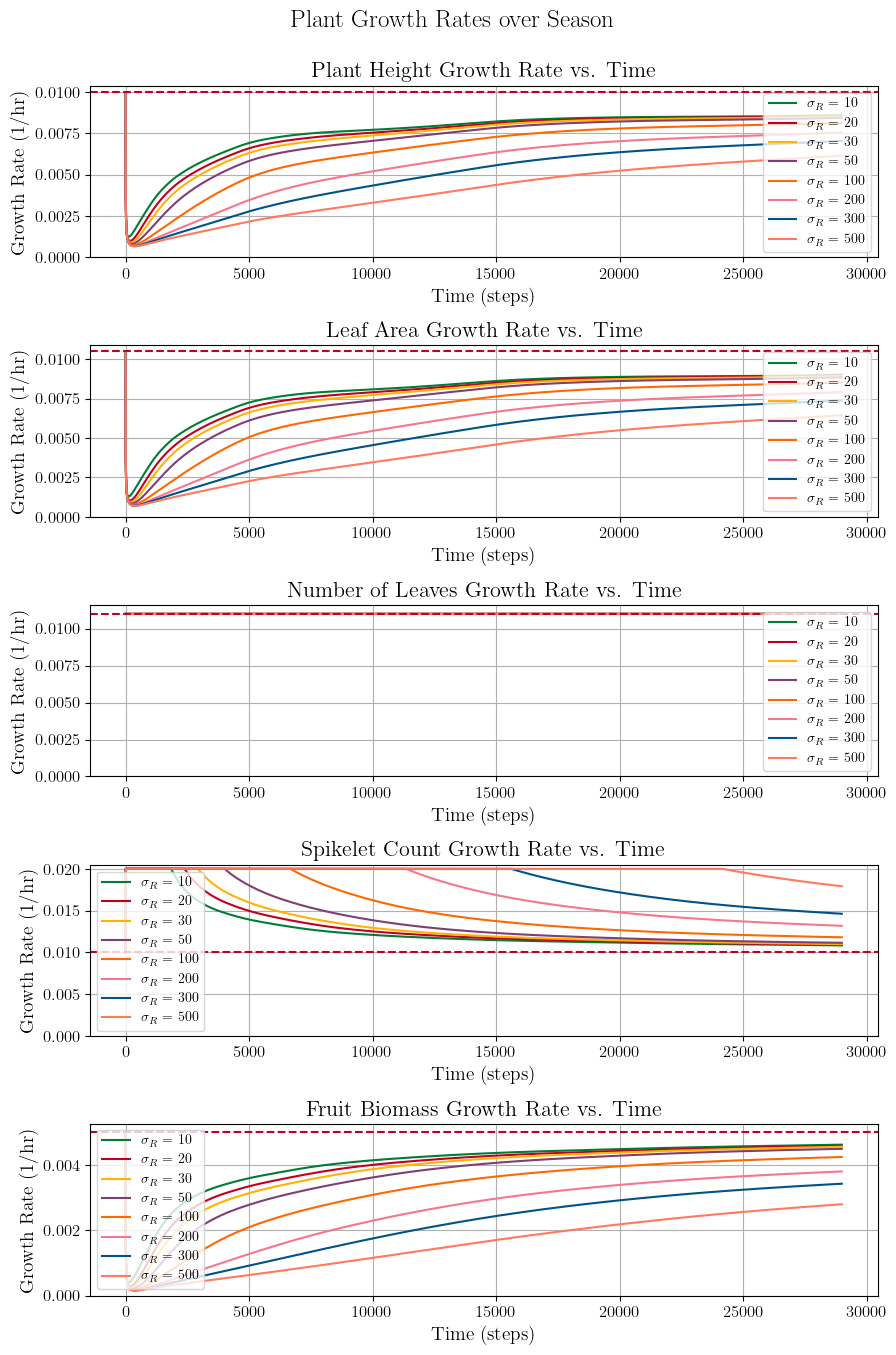

In [32]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
plot_growth_rate_evolution(
    growth_rates=growth_rates,
    ah_hats=ah_hats,
    aA_hats=aA_hats,
    aN_hats=aN_hats,
    ac_hats=ac_hats,
    aP_hats=aP_hats,
    labels=labels
)

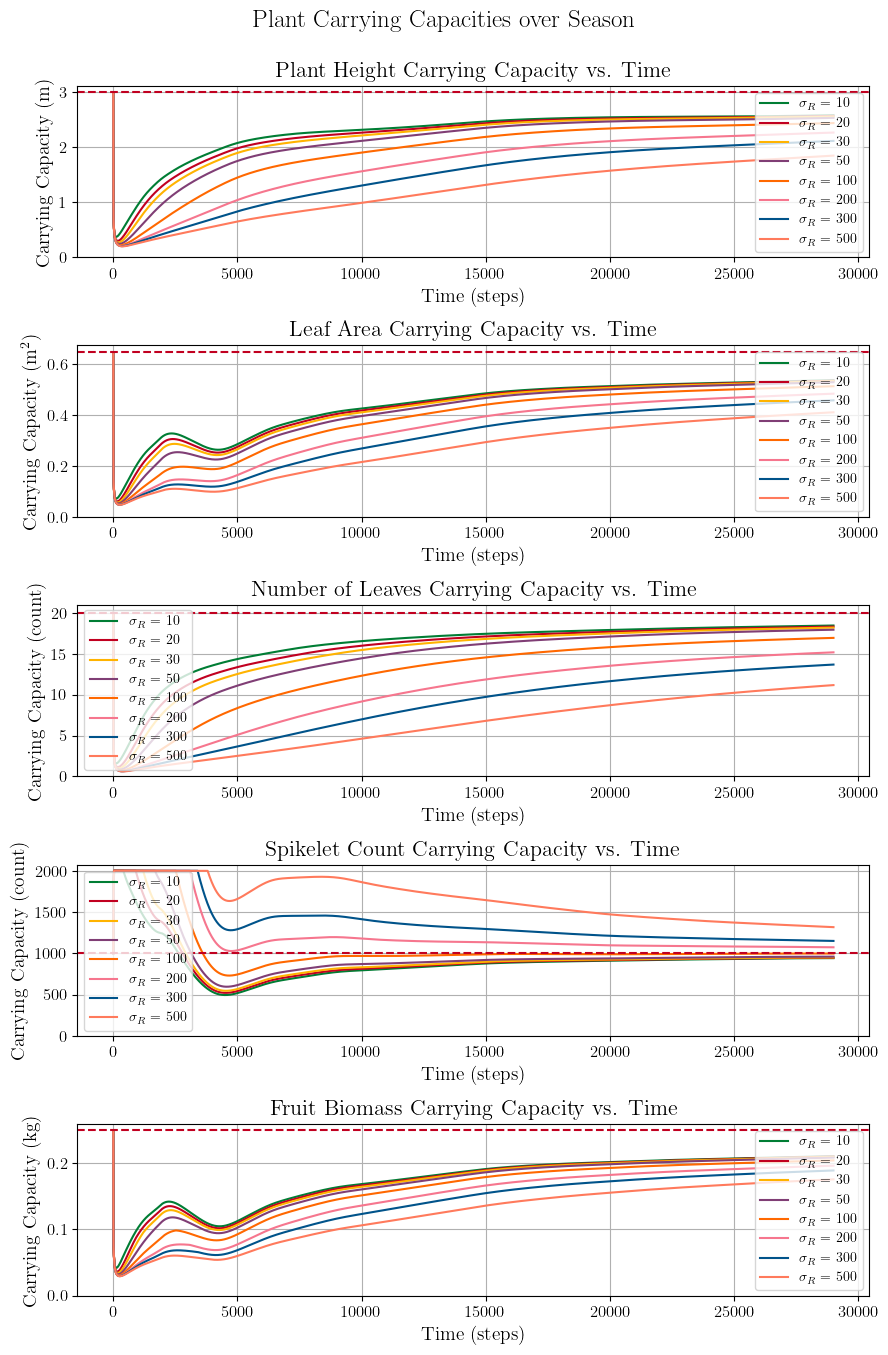

In [33]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
plot_carrying_capacity_evolution(
    carrying_capacities=carrying_capacities,
    kh_hats=kh_hats,
    kA_hats=kA_hats,
    kN_hats=kN_hats,
    kc_hats=kc_hats,
    kP_hats=kP_hats,
    labels=labels
)